# Create a sequence generator with GAN
In this notebook, we develog a GAN network with Recurrent Neural Network (RNN) to create a Galician language sequence generator. In this project, we use text from the Galician politician Beiras. 

**A GAN network does not work in this case**

This work is based on 
https://github.com/udacity/aind2-rnn/blob/master/RNN_project.ipynb
    
The GAN implementation is based on https://github.com/osh/KerasGAN/blob/master/MNIST_CNN_GAN.ipynb    

## Load the data
First we load the data and preprocess:
* Lower
* remove lines with http links
* remove symbols: '[ºªàâäçèêïìôöü&%@•…«»”“*/!"(),.:;_¿¡¿‘’´\[\]\']'

In [2]:
import numpy as np
from beiras_aux import LoadText,print_predicctions

In [3]:
window_size = 100
step_size = 1
X,y,chars,chars_to_indices,indices_to_chars,text_clean=LoadText('Beiras.txt',window_size,step_size);

MemoryError: 

* X .- Array shape (sentences, window_size, num_chars) .- Input for training.
* y .- Array shape (sentences, num_chars) .- Output for training.
* chars . -Array with chars we have in the clean text
* chars_to_indices,indices_to_chars .- dictionaries to convert fron number to char and char to index
* text_clean .- All the text clean.

## Test we have a GPU
I used a g2.2xlarge EC2 machine. Without a GPU this is too slow.

In [11]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15587238462670927579, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 3879469056
 locality {
   bus_id: 1
 }
 incarnation: 17891074825725798988
 physical_device_desc: "device: 0, name: GRID K520, pci bus id: 0000:00:03.0"]

## Auxiliar functions

In [6]:
# Make a network trainable
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [7]:
# We use a small data, because this network needs more memory
Xsmall = X[:10000,:,:]
ysmall = y[:10000,:]

In [8]:
# Plot the loss
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()

 ## Create the network 

In [9]:
from keras.optimizers import Adam
from keras.layers import Input
from keras.layers.recurrent import GRU
from keras.models import Model
from keras.layers.core import Dense
from keras.layers import Concatenate,concatenate,Reshape

def create_gan_simple_model(chars,shp):
    num_chars = len(chars)
    opt = Adam(lr=1e-4)
    dopt = Adam(lr=1e-3)
    
    # Generator
    g_input = Input(shape=shp)
    H=GRU(200)(g_input)
    g_V=Dense(num_chars,activation='softmax')(H)
    generator = Model(g_input,g_V)
    generator.compile(loss='binary_crossentropy', optimizer=opt)
    generator.summary()
    
    #Distriminator
    shp_discriminator=(shp[0]+1,shp[1])
    print(shp_discriminator)
    d_input = Input(shape=shp_discriminator)
    H=GRU(200)(d_input)
    d_V=Dense(2,activation='softmax')(H)
    discriminator = Model(d_input,d_V)
    discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
    discriminator.summary()
        
    make_trainable(discriminator, False)
    
    #GAN 
    gan_input = Input(shape=shp)
    H = generator(gan_input)
    print(gan_input.shape,H.shape)
    print(H.shape[1],num_chars)
    H = Reshape((1,num_chars))(H)
    print(gan_input.shape,H.shape)
    H=concatenate([gan_input,H],axis=1)
    print(H.shape)
    gan_V = discriminator(H)
    GAN = Model(gan_input, gan_V)
    GAN.compile(loss='categorical_crossentropy', optimizer=opt)
    GAN.summary()
    
    return generator,discriminator,GAN

In [10]:
generator,discriminator,GAN=create_gan_simple_model(chars,X.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 55)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 200)               153600    
_________________________________________________________________
dense_3 (Dense)              (None, 55)                11055     
Total params: 164,655
Trainable params: 164,655
Non-trainable params: 0
_________________________________________________________________
(101, 55)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 101, 55)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 200)               153600    
____________________________________________________________

In [89]:
from tqdm import tqdm
def train_for_n(X,y,nb_epoch=30, plt_frq=25,batch_size=32):
    losses = {"d":[], "g":[]}
    y=np.reshape(y,(y.shape[0],1,y.shape[1]))
    for e in tqdm(range(nb_epoch)):  
        for jj in range(X.shape[0]//batch_size):
            # Make generative images 
            random_index_gen=np.random.randint(0,X.shape[0],size=batch_size)
            text_batch_gen=X[random_index_gen,:,:]
        
            random_index_dis=np.random.randint(0,X.shape[0],size=batch_size)
            text_batch_dis=X[random_index_dis,:,:]
            text_batch_dis= np.concatenate((text_batch_dis,y[random_index_dis,:]),axis=1)
        
            generated_text = generator.predict(text_batch_gen)
            generated_text=np.reshape(generated_text,(generated_text.shape[0],1,generated_text.shape[1]))
            generated_text=np.concatenate((text_batch_gen,generated_text),axis=1)
            # Train discriminator on generated images
            X_dis = np.concatenate(( text_batch_dis,generated_text))
            y_dis = np.zeros([2*batch_size,2])
            y_dis[0:batch_size,1] = 1
            y_dis[batch_size:,0] = 1
        
            make_trainable(discriminator,True)
            d_loss  = discriminator.train_on_batch(X_dis,y_dis)
            losses["d"].append(d_loss)
    
            # train Generator-Discriminator stack on input noise to non-generated output class
            make_trainable(discriminator,False)
            random_index_gan=np.random.randint(0,X.shape[0],size=batch_size)
            text_batch_gan=X[random_index_gan,:,:]
            y2 = np.zeros([batch_size,2])
            y2[:,1] = 1
        
        
            g_loss = GAN.train_on_batch(text_batch_gan, y2 )
            losses["g"].append(g_loss)
        
            #Updates plots
            if jj%plt_frq==plt_frq-1:
                plot_loss(losses)
                print_predicctions(generator)
            
    generator.save_weights('model_weights/best_beiras_gan_textdata_weights.hdf5')         

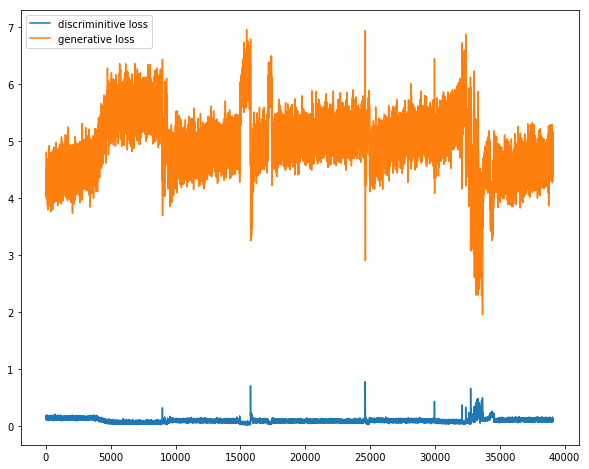

------------------
input chars = 
pla panfletaria contra as leoninas taxas impostas polo ministro de xustiza actual malia que vulneran"

predicted chars = 
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo"

------------------
input chars = 
poema de rosalía titulado a xusticia pola man e dado á luz no seu libro follas novas por certo que s"

predicted chars = 
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo"

------------------
input chars = 
se moito cando dixen eu que as suas políticas agresoras do común cidadán matan e a sua cospedal alcu"

predicted chars = 
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo"



100%|██████████| 10/10 [13:31:43<00:00, 4870.36s/it] 


In [90]:
train_for_n(X,y,nb_epoch=10, plt_frq=100,batch_size=300)


In [11]:
print_predicctions(generator)
generator.save_weights('model_weights/best_beiras_gan_textdata_weights.hdf5',
                   chars_to_indices,indices_to_chars,text_clean,window_size)

pla panfletaria contra as leoninas taxas impostas polo ministro de xustiza actual malia que vulneran....qíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõnqíõn
poema de rosalía titulado a xusticia pola man e dado á luz no seu libro follas novas por certo que s....këxëxhëo­­2bddy–hb1ko­2—fáááá3nqíqõl9éhëxëxhëo­­2bddy–hb1ko­2—fáááá3nqíqõl9éhëxëxhëo­­2bddy–hb1ko­2—
se moito cando dixen eu que as suas políticas agresoras do común cidadán matan e a sua cospedal alcu....z—fpp1kv-ëxëxëxhëo­­2bddy–hb1ko­2—fáááá3nqíqõl9éhëxëxhëo­­2bddy–hb1ko­2—fáááá3nqíqõl9éhëxëxhëo­­2bdd
